# DATASET downlaod & unzip

In [72]:
!wget 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

--2020-08-05 00:10:13--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.1’

cifar-10-python.tar 100%[===================>] 162.60M  52.3MB/s    in 3.4s    

2020-08-05 00:10:17 (47.6 MB/s) - ‘cifar-10-python.tar.gz.1’ saved [170498071/170498071]



In [73]:
 import tarfile

 tarfile.open('cifar-10-python.tar.gz', 'r:gz').extractall()

In [74]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [75]:
batch_meta = unpickle('cifar-10-batches-py/batches.meta')

In [76]:
print(batch_meta.keys())

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])


In [77]:
print(batch_meta[b'label_names'])

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


In [78]:
import os

file_name = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
label_tr = []
img_tr = []
data_path = 'cifar-10-batches-py'
for i in file_name:
    i = unpickle(os.path.join(data_path, i))
    for a in i[b'labels']:
        label_tr.append(a)
    for b in i[b'data']:
        img_tr.append(b)

label_test = []
img_test = []
test_name = ['test_batch']
for i in test_name:
    i = unpickle(os.path.join(data_path, i))
    for a in i[b'labels']:
        label_test.append(a)
    for b in i[b'data']:
        img_test.append(b)

In [79]:
import random


label_val = []
img_val = []
for _ in range(int(len(label_tr)*0.2)):
    index = random.choice(range(1, len(label_tr)))
    label_val.append(label_tr[index])
    img_val.append(img_tr[index])
    del label_tr[index]
    del img_tr[index]    

print(len(label_tr))
print(len(img_tr))
print(len(label_val))
print(len(img_val))
print(len(label_test))
print(len(img_test))

40000
40000
10000
10000
10000
10000


In [80]:
print(img_tr[0].shape)
print(type(label_tr[0]))

(3072,)
<class 'int'>


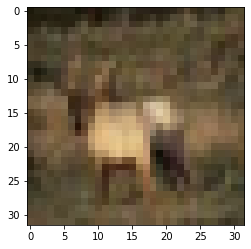

In [97]:
from matplotlib.pyplot import imshow
from PIL import Image

%matplotlib inline
imshow(img_tr[2].reshape(3, 32, 32).transpose(1, 2, 0))

# Dataset & Dataloader

In [126]:
import numpy as np
from torch.utils.data import Dataset, DataLoader

class Cifar10_DataSet(Dataset):
    def __init__(self, labels, imgs):
        self.labels = labels
        self.imgs = imgs
    
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img = np.asarray(self.imgs[index])
        img = img.reshape(3, 32, 32)
        label = np.asarray(self.labels[index])

        return torch.from_numpy(img), torch.from_numpy(label)

In [127]:
#TODO: dataset transformer & augmentation 만들기
from torchvision.transforms import Normalize
transforms = Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [128]:
dataset_tr = Cifar10_DataSet(label_tr, img_tr)
dataset_val = Cifar10_DataSet(label_val, img_val)
dataset_test = Cifar10_DataSet(label_test, img_test)

In [129]:
tr_dataloader = DataLoader(dataset_tr, batch_size=512, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=512, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=512, shuffle=False)

# Model & Training

In [146]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 24, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(24 * 4 * 4, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x.float())))  # output = 64, 28/2, 28/2
        x = self.pool(F.relu(self.conv2(x)))  # output = 64, 12/2, 12/2
        x = F.relu(self.conv3(x))  # output = 24, 4, 4
        x = x.view(-1, 24 * 4 * 4)
        x = F.softmax(self.fc1(x), dim=1)
        return x

In [147]:
import torch
print(torch.cuda.is_available)
device = torch.device("cuda:0")

<function is_available at 0x7f55664a9488>


In [174]:
import torch
import torch.optim as optim
# import queue

model = Model()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

count = 0
val_loss_que = []
for epoch in range(1000):
    train_loss = 0
    for i, (inputs, labels) in enumerate(tr_dataloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        train_loss += loss.item()

        optimizer.step()

    val_loss = 0
    for i, data in enumerate(val_dataloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        val_loss += loss.item()

    train_loss /= len(tr_dataloader)
    val_loss /= len(val_dataloader)
    val_loss_que.append(val_loss)
    
    if epoch+1 >= 20:
        # print(len(val_loss_que))
        pre_val = sum(val_loss_que)/20
        if pre_val <= val_loss:
            count += 1
            if count ==5:
                print('early stopping')
                break    
        else:
            count = 0

        del val_loss_que[0]
        print('[{} epoch] tr_loss: {:.4f}  val_loss: {:.4f}  pre_mean val_loss:  {:.4f}  early stopping ccount:  {}'.format(epoch + 1, train_loss, val_loss, pre_val, count))
    else:
        print('[{} epoch] tr_loss: {:.4f}  val_loss: {:.4f}'.format(epoch + 1, train_loss, val_loss))
        
    

[1 epoch] tr_loss: 2.2834  val_loss: 2.2271
[2 epoch] tr_loss: 2.2372  val_loss: 2.1905
[3 epoch] tr_loss: 2.1669  val_loss: 2.1187
[4 epoch] tr_loss: 2.1028  val_loss: 2.0704
[5 epoch] tr_loss: 2.0450  val_loss: 1.9928
[6 epoch] tr_loss: 2.0229  val_loss: 1.9127
[7 epoch] tr_loss: 2.0066  val_loss: 1.9503
[8 epoch] tr_loss: 1.9898  val_loss: 1.9615
[9 epoch] tr_loss: 1.9740  val_loss: 1.8243
[10 epoch] tr_loss: 1.9671  val_loss: 1.9565
[11 epoch] tr_loss: 1.9535  val_loss: 1.9442
[12 epoch] tr_loss: 1.9444  val_loss: 1.8198
[13 epoch] tr_loss: 1.9388  val_loss: 1.9298
[14 epoch] tr_loss: 1.9307  val_loss: 1.9394
[15 epoch] tr_loss: 1.9274  val_loss: 1.9210
[16 epoch] tr_loss: 1.9186  val_loss: 1.8816
[17 epoch] tr_loss: 1.9171  val_loss: 1.8614
[18 epoch] tr_loss: 1.9110  val_loss: 1.8717
[19 epoch] tr_loss: 1.9079  val_loss: 1.8403
[20 epoch] tr_loss: 1.9015  val_loss: 1.8438  pre_mean val_loss:  1.9529  early stopping ccount:  0
[21 epoch] tr_loss: 1.8991  val_loss: 1.7925  pre_mean

# Evaluation

In [175]:
# from Jeongho_Kim's HW2
# : https://github.com/cutz-j/Deeplearning/blob/master/hw2/%5BJeongho_Kim%5DCIFAR_10.ipynb
def top5acc(y_pred, y_val):
    np_y_pred = y_pred.cpu().numpy()
    np_y_val = y_val.cpu().numpy()
    correct = 0
    for i in range(np_y_pred.shape[0]):
        if np_y_val[i] in np.argsort(np_y_pred[i])[-5:]:
            correct +=1 
    return correct


total = 0
correct_1 = 0
correct_5 = 0

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_dataloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted_1 = torch.max(outputs.data, 1)
        # _, predicted_5 = torch.topk(outputs.data, 5)
        # _, predicted_5 = torch.max(outputs.data, 5)

        total += labels.size(0)
        correct_1 += (labels.data == predicted_1).sum().item()
        correct_5 += top5acc(outputs.data, labels.data)
        
print('top1 accuracy: {:.1f}'.format(correct_1/total*100))
print('top5 accuracy: {:.1f}'.format(correct_5/total*100))

top1 accuracy: 65.3
top5 accuracy: 95.9
